# Preliminaries

This is to ensure that torch recognizes macOS software. 

In [2]:
import torch 
print("PyTorch Ver:", torch.__version__) 
print("Apple Silicon available:", torch.backends.mps.is_available())

device = torch.device("mps")

PyTorch Ver: 2.6.0
Apple Silicon available: True


# Imports 

In [14]:
import torch.nn as nn 
import matplotlib.pyplot as plt 
import torch.optim as optimizer 

import gradio as gr

# Create the Model

Creating a simple neural network with torch for nonlinear regression.


In [4]:
class SimpleNN(nn.Module): # SimpleNN inherits nn.Module from here 
    def __init__(self, input_dim, hidden_dim1=6, hidden_dim2=4):
        super(SimpleNN, self).__init__()  # calls the parent class nn.Module to get pytorch backend set up 
        # Layers 
        self.fc1 = nn.Linear(input_dim, hidden_dim1)  # fc stands for "fully connected" 
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, 1)
        
        self.relu = nn.ReLU() 
    
    def forward(self, x):
        x = self.relu(self.fc1(x)) # hidden layer 1 
        x = self.relu(self.fc2(x)) # hidden layer 2
        x = self.fc3(x)            # output layer (unbounded since lin reg)
        return x

# Creating a Dummy Dataset

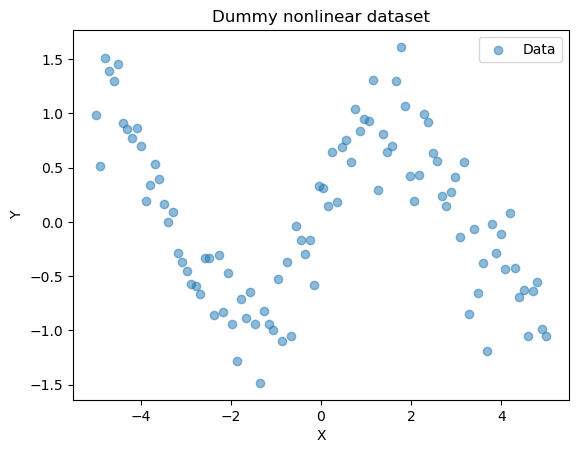

In [8]:
# Generate dataset y = f(x) 
X = torch.linspace(-5, 5, 100).view(-1, 1)
y = torch.sin(X) + torch.randn(X.shape) * 0.35

D = {"X": X, "y": y}

# Plot 
plt.scatter(D["X"].numpy(), D["y"].numpy(), label="Data", alpha=0.5)
plt.xlabel("X") 
plt.ylabel("Y") 
plt.title("Dummy nonlinear dataset")
plt.legend()
plt.show()


# Training Loop


In [53]:
def train(model, dataset, criterion, optimizer, device, epochs=5): 
    """
    Trains the model on the dataset. 

    Args: 
        model: the simple NN model with one hidden layer. 
        dataset: the dataset, a dictionary = {"X": X, "y":y}
        criterion: the loss function to use. 
        optimizer: the type of optimizer to use. 
        epochs: the number of epochs. 
    """
    model = model.to(device) # change all model weights to mps 
    
    model.train() # set the model to train mode (for pytorch)

    final_loss = 0 

    for epoch in range(epochs):       
        optimizer.zero_grad()

        # get data 
        x = dataset["X"]
        y = dataset["y"] 

        x = x.to(device)
        y = y.to(device)

        # forward pass on nn 
        y_hat = model.forward(x) 
        
        loss = criterion(y_hat, y)

        # run back prop on loss to update gradients 
        loss.backward() 

        # update weights 
        optimizer.step() 

        if epoch == epochs - 1:
            final_loss = loss.item()
    
    return final_loss
    


# Create and Train the Model

In [57]:
def create_model(lr, epochs, h1, h2):
    """
    lr: Learning Rate 
    epochs: Epochs 
    h1: Size of hidden layer 1 
    h2: Size of hidden layer 2 
    """
    input_dim = 1 

    model = SimpleNN(input_dim, h1, h2)
    model_optimizer = optimizer.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    dataset = D 
    print("Training the Neural Network:")
    loss = train(model, dataset, criterion, model_optimizer, device, epochs=int(epochs))

    return model, loss

# Evaluating and Visualizing the Model

In [50]:
def evaluate_model(epochs, lr, hidden_dim1, hidden_dim2):
    model,_ = create_model(epochs, lr, hidden_dim1, hidden_dim2)

    # Change the model to evaluation mode (changes some backend stuff in PyTorch)
    model.eval() 
    with torch.no_grad(): 
        y_pred = model.forward(X)

    plt.figure(figsize=(10, 6)) 
    plt.scatter(X.to("cpu"), y.to("cpu"), label="True Data", color="blue")
    plt.plot(X.to("cpu"), y_pred.to("cpu"), label="Model Predictions", color="red", linewidth=2)
    plt.xlabel("Input Feature") 
    plt.ylabel("Target Value") 
    plt.title("Regression: True vs Predicted")
    plt.legend()
    plt.show()

# Create the Gradio Interface

### Create a Trainer Class to easily update hyper parameters

In [59]:
class Trainer(): 
    def __init__(self): 
        self.params = {
            "lr": 0.01, 
            "epochs": 10, 
            "h1": 6, 
            "h2": 4,
        }
    
    def update_params(self, **kwargs): 
        for key, value in kwargs.items(): 
            if key in self.params:
                self.params[key] = value
        return self.params 
    
    def create_and_train(self): 
        _, loss = create_model(**self.params) 
        return f"Loss: {loss:.4f}"

In [60]:
trainer = Trainer()

with gr.Blocks() as view: 
    # Create the UI Components 
    lr = gr.Slider(0.001, 1, value=0.01, label="Learning Rate (alpha)")
    epochs = gr.Slider(1, 1000, value=5, step = 1, label="Epochs")
    h1 = gr.Slider(1, 10, value=6, step=1, label = "Size of first hidden layer")
    h2 = gr.Slider(1, 10, value=6, step=1, label = "Size of second hidden layer")
    train_btn = gr.Button("Train")
    output = gr.Textbox(label= "Results")

    # Connect events 
    lr.change(lambda x: trainer.update_params(learning_rate=x), lr, None)
    epochs.change(lambda x: trainer.update_params(epochs=x), epochs, None)
    h1.change(lambda x: trainer.update_params(h1=x), h1, None) 
    h2.change(lambda x: trainer.update_params(h2=x), h2, None)
    train_btn.click(trainer.create_and_train, inputs=None, outputs= output)

view.launch()





Running on local URL:  http://127.0.0.1:7875

To create a public link, set `share=True` in `launch()`.


Training the Neural Network:
Training the Neural Network:
Training the Neural Network:
Training the Neural Network:
Training the Neural Network:
Training the Neural Network:
Training the Neural Network:
Training the Neural Network:
Training the Neural Network:
